In [1]:
print('f')

f


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = './pj'
output_dir = './pj_split'
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Train, val 폴더 생성
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(output_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', cls), exist_ok=True)
    
    class_dir = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
        
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))

print("Data splitting completed.")

Data splitting completed.


Epoch 0/9
train Loss: 0.9596 Acc: 0.6873 Recall: 0.6318
val Loss: 0.5968 Acc: 0.7969 Recall: 0.7815

Epoch 1/9
train Loss: 0.5717 Acc: 0.8152 Recall: 0.7761
val Loss: 0.6447 Acc: 0.8132 Recall: 0.7906

Epoch 2/9
train Loss: 0.4195 Acc: 0.8677 Recall: 0.8365
val Loss: 0.4072 Acc: 0.8764 Recall: 0.8391

Epoch 3/9
train Loss: 0.3209 Acc: 0.8982 Recall: 0.8745
val Loss: 0.4288 Acc: 0.8736 Recall: 0.8551

Epoch 4/9
train Loss: 0.2408 Acc: 0.9234 Recall: 0.9039
val Loss: 0.3462 Acc: 0.9015 Recall: 0.8824

Epoch 5/9
train Loss: 0.1867 Acc: 0.9393 Recall: 0.9239
val Loss: 0.3308 Acc: 0.9142 Recall: 0.8953

Epoch 6/9
train Loss: 0.1618 Acc: 0.9483 Recall: 0.9362
val Loss: 0.3474 Acc: 0.9089 Recall: 0.8769

Epoch 7/9
train Loss: 0.1280 Acc: 0.9569 Recall: 0.9471
val Loss: 0.4204 Acc: 0.8897 Recall: 0.8509

Epoch 8/9
train Loss: 0.1102 Acc: 0.9642 Recall: 0.9554
val Loss: 0.3861 Acc: 0.9057 Recall: 0.8740

Epoch 9/9
train Loss: 0.1037 Acc: 0.9671 Recall: 0.9600
val Loss: 0.3557 Acc: 0.9138 Recall

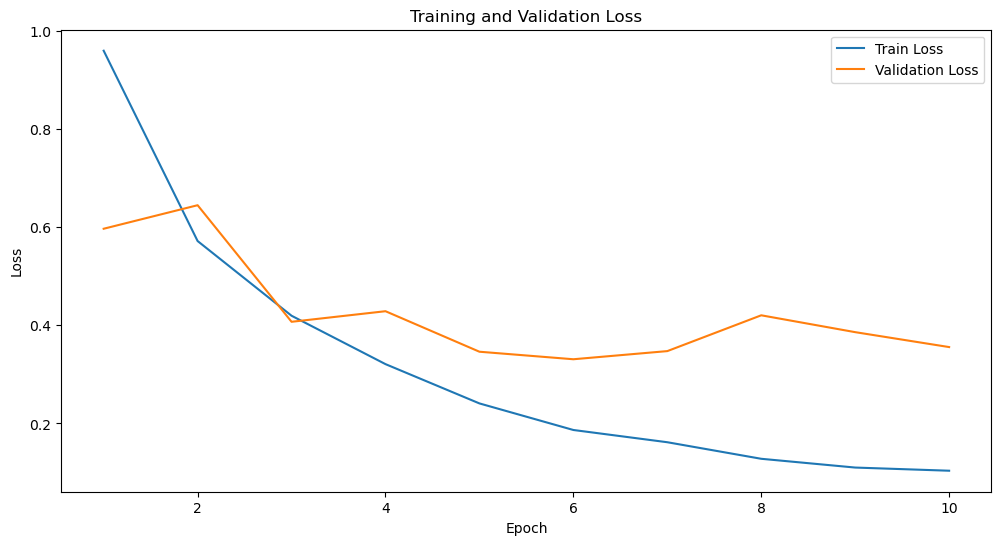

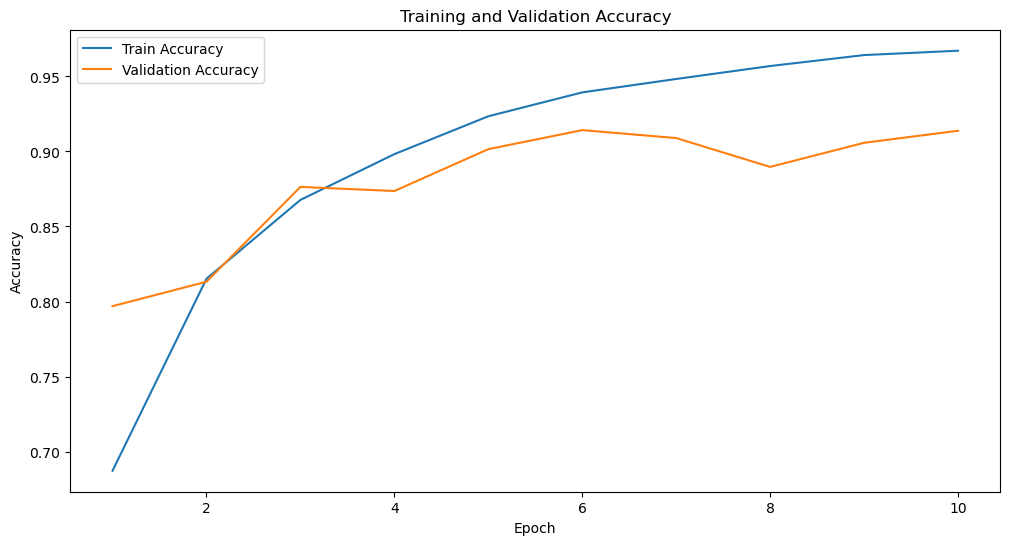

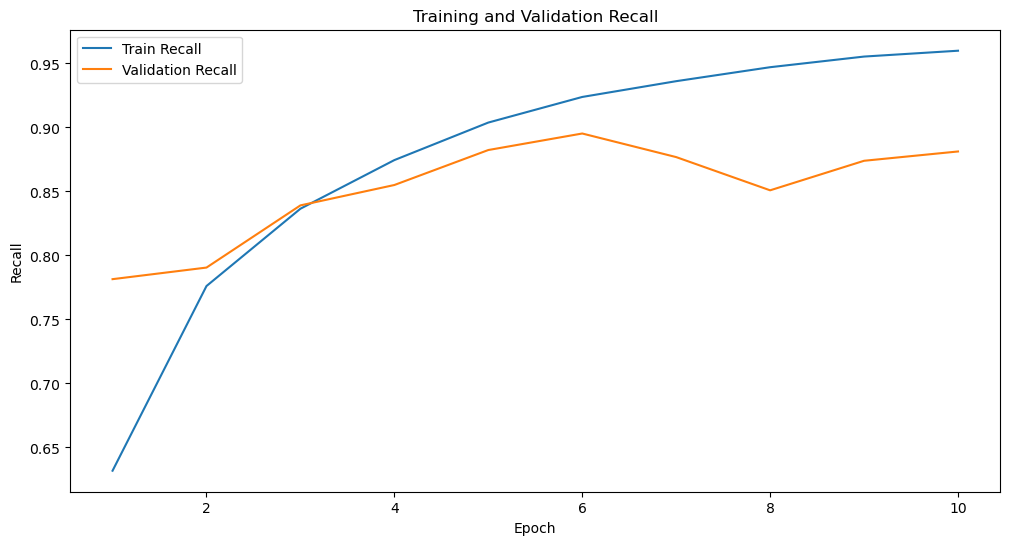

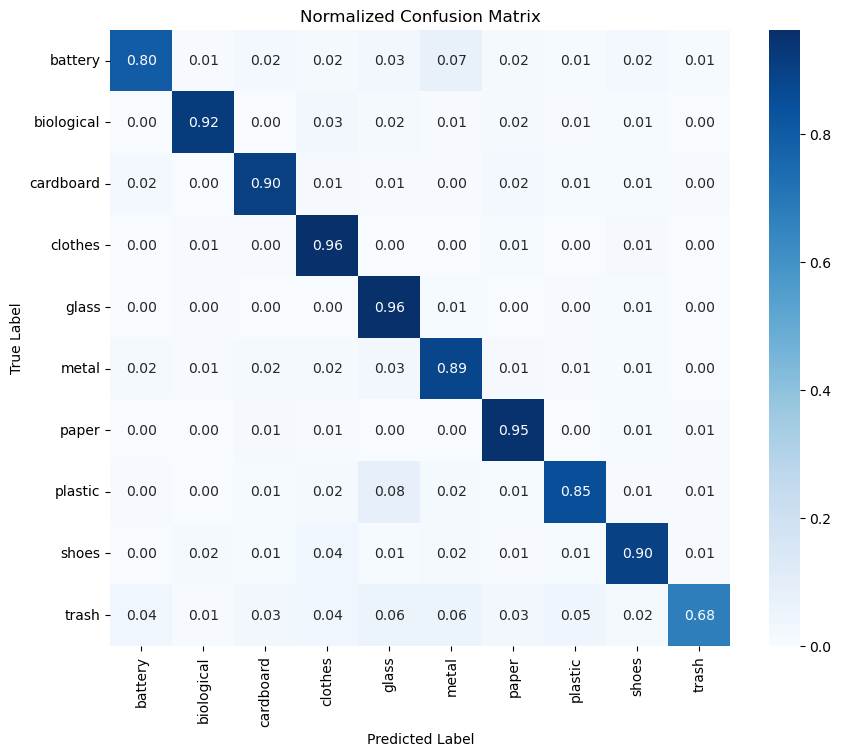

In [7]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
import numpy as np

# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './pj_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ResNet-18 모델 불러오기 및 수정
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# 학습 및 평가 함수
def train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    train_recall_history = []
    val_recall_history = []
    
    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_str = f'Epoch {epoch}/{start_epoch + num_epochs - 1}'
        print(epoch_str)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # GPU 메모리 정리
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                train_recall_history.append(epoch_recall)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_recall_history.append(epoch_recall)
            
            log_str = f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {epoch_recall:.4f}'
            print(log_str)
        
        print()

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history = train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10)

# 모델 저장
torch.save(model.state_dict(), 'recycle_classification_model_resnet18.pth')

# 시각화
epochs = list(range(1, len(train_loss_history) + 1))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_recall_history, label='Train Recall')
plt.plot(epochs, val_recall_history, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()

# 모델 평가 및 혼동 행렬 계산 함수
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# 클래스 이름 설정
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

# 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)


Epoch 10/29
train Loss: 0.0824 Acc: 0.9749 Recall: 0.9680
val Loss: 0.3767 Acc: 0.9087 Recall: 0.8749

Epoch 11/29
train Loss: 0.0860 Acc: 0.9729 Recall: 0.9669
val Loss: 0.3820 Acc: 0.9013 Recall: 0.8757

Epoch 12/29
train Loss: 0.0655 Acc: 0.9782 Recall: 0.9730
val Loss: 0.3794 Acc: 0.9057 Recall: 0.8757

Epoch 13/29
train Loss: 0.0607 Acc: 0.9806 Recall: 0.9754
val Loss: 0.4699 Acc: 0.9017 Recall: 0.8764

Epoch 14/29
train Loss: 0.0747 Acc: 0.9774 Recall: 0.9732
val Loss: 0.3597 Acc: 0.9169 Recall: 0.9032

Epoch 15/29
train Loss: 0.0603 Acc: 0.9809 Recall: 0.9770
val Loss: 0.3823 Acc: 0.9068 Recall: 0.8849

Epoch 16/29
train Loss: 0.0512 Acc: 0.9841 Recall: 0.9801
val Loss: 0.4168 Acc: 0.9104 Recall: 0.8855

Epoch 17/29
train Loss: 0.0555 Acc: 0.9837 Recall: 0.9801
val Loss: 0.3969 Acc: 0.9079 Recall: 0.8860

Epoch 18/29
train Loss: 0.0427 Acc: 0.9865 Recall: 0.9843
val Loss: 0.4297 Acc: 0.9034 Recall: 0.8785

Epoch 19/29
train Loss: 0.0512 Acc: 0.9843 Recall: 0.9813
val Loss: 0.459

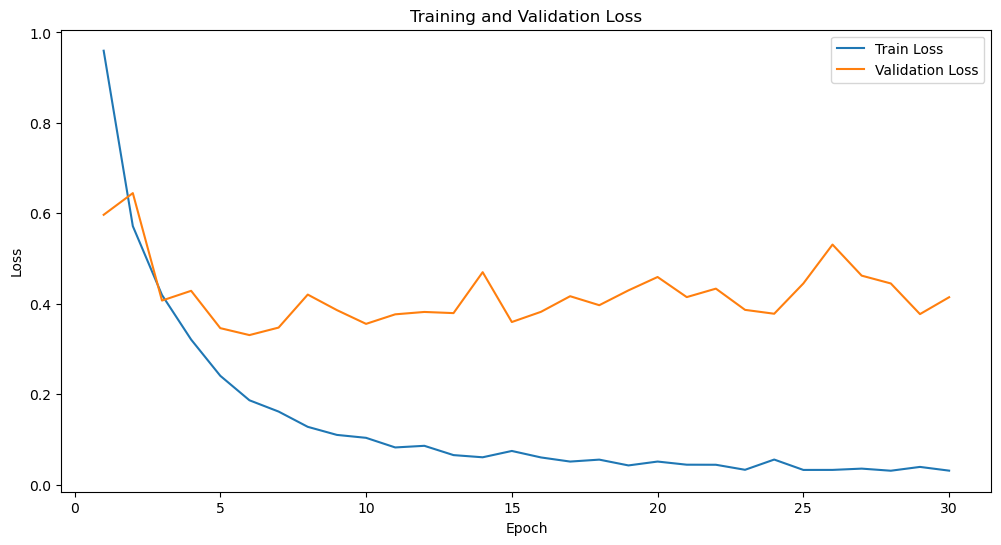

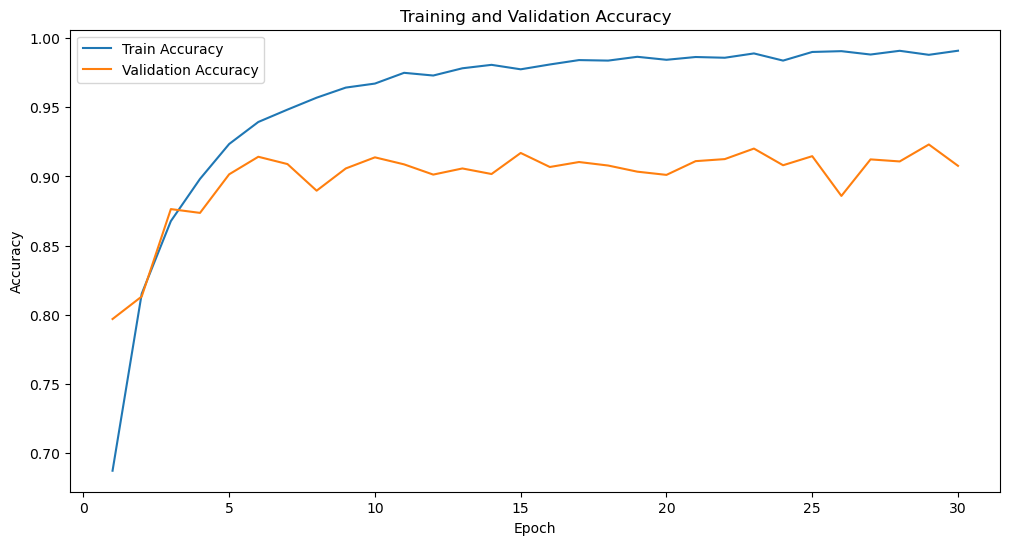

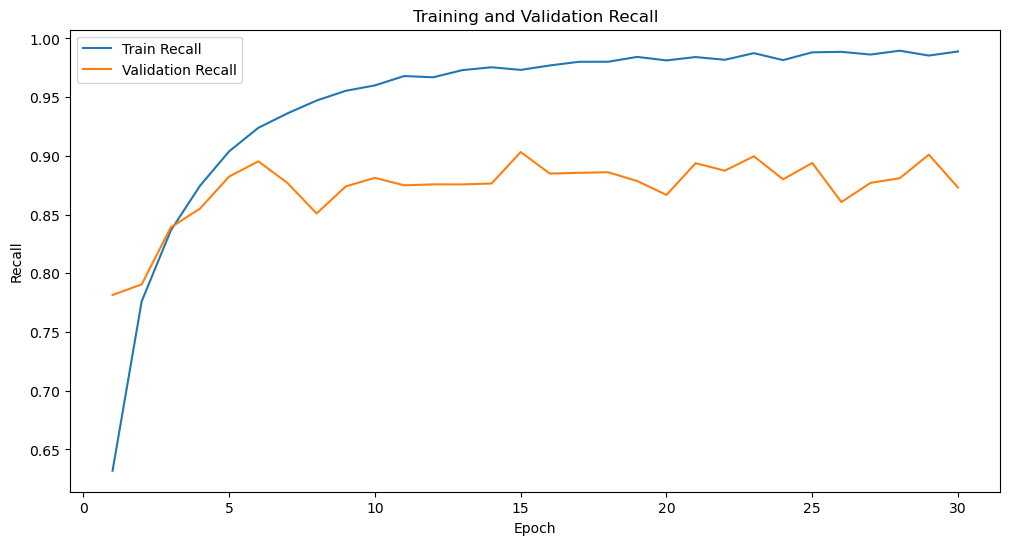

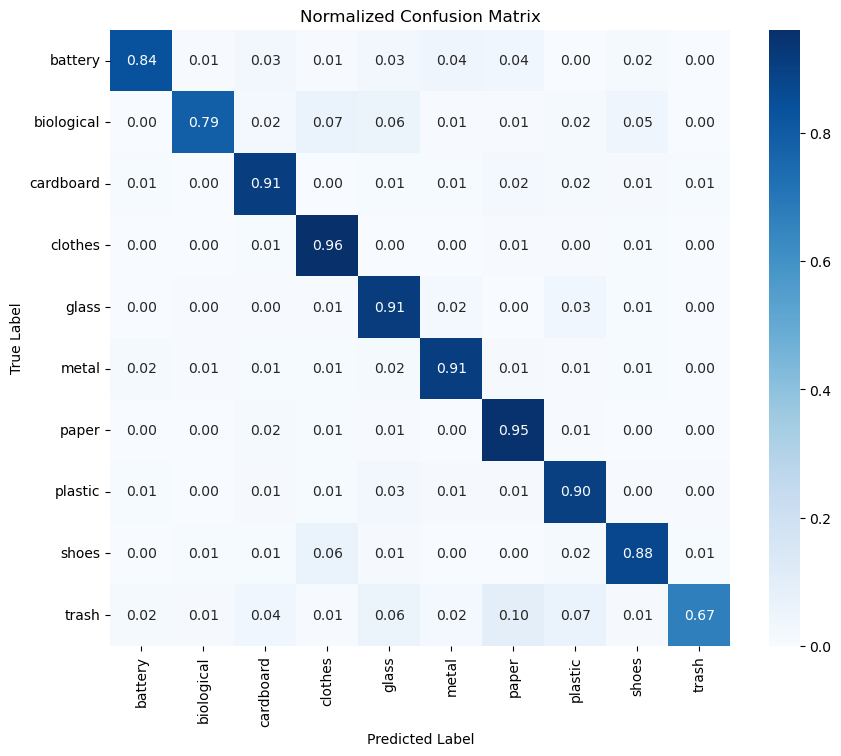

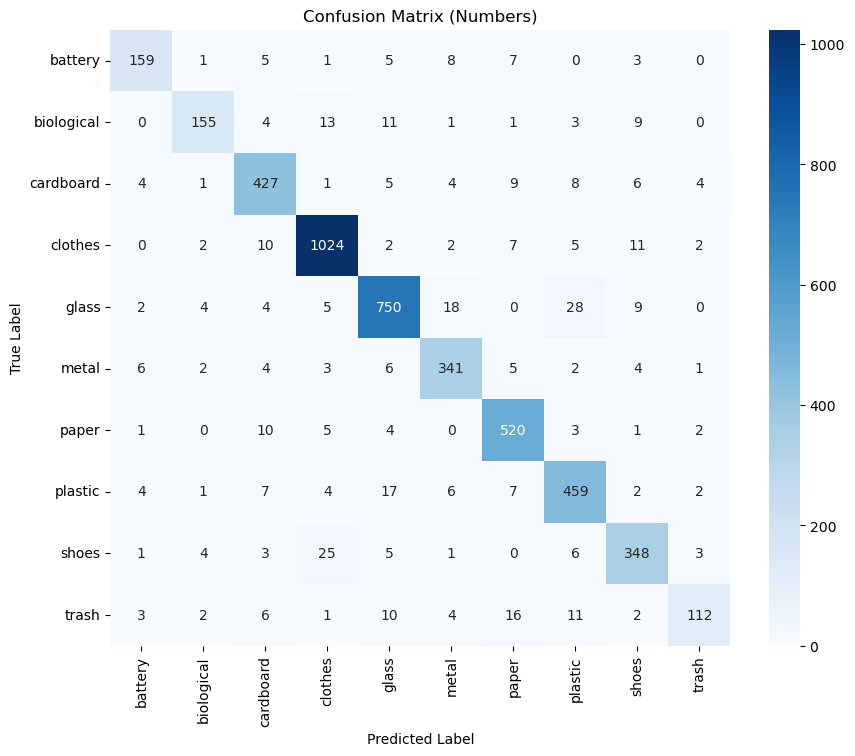

In [11]:
# 기존 모델 상태 불러오기
model.load_state_dict(torch.load('recycle_classification_model_resnet18.pth'))

# 추가 학습 수행
additional_model, additional_train_loss, additional_val_loss, additional_train_acc, additional_val_acc, additional_train_recall, additional_val_recall = train_model(model, criterion, optimizer, start_epoch=10, num_epochs=20)

# 기존 기록에 추가 학습 기록을 병합
train_loss_history.extend(additional_train_loss)
val_loss_history.extend(additional_val_loss)
train_acc_history.extend(additional_train_acc)
val_acc_history.extend(additional_val_acc)
train_recall_history.extend(additional_train_recall)
val_recall_history.extend(additional_val_recall)

# 모델 저장 (추가 학습 후)
torch.save(model.state_dict(), 'recycle_classification_model_resnet18_further.pth')

# 시각화 업데이트
epochs = list(range(1, len(train_loss_history) + 1))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_recall_history, label='Train Recall')
plt.plot(epochs, val_recall_history, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()

# 혼동 행렬 시각화 업데이트
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 시각화 - 비율
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    # 혼동 행렬 시각화 - 숫자
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Numbers)')
    plt.show()

# 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)


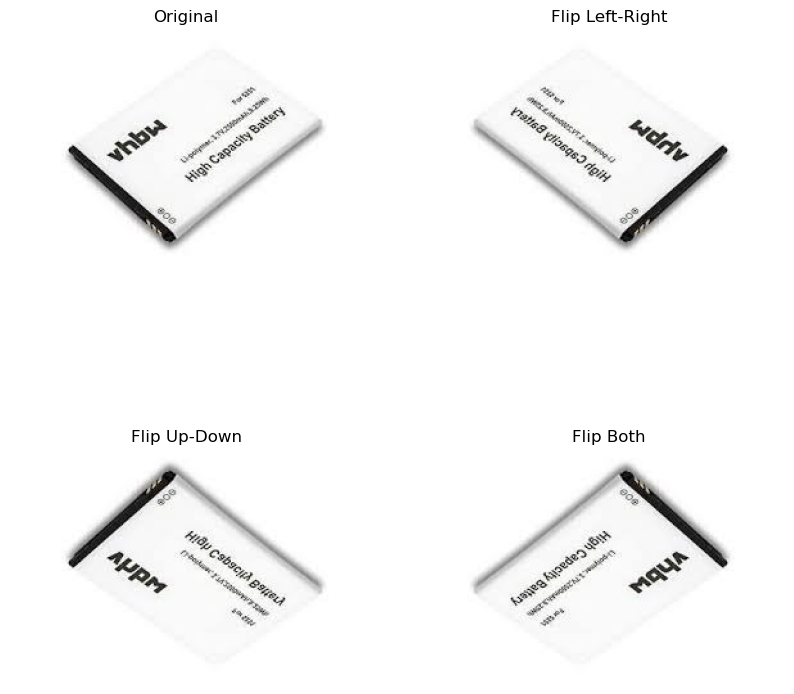

In [15]:
import cv2
import os
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read image: {image_path}")
    # OpenCV는 BGR 형식으로 이미지를 읽기 때문에 RGB로 변환
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_flipped_images(image):
    # 좌우 반전
    img_flip_lr = cv2.flip(image, 1)
    # 상하 반전
    img_flip_ud = cv2.flip(image, 0)
    # 상하좌우 반전
    img_flip_both = cv2.flip(image, -1)

    # 이미지 시각화
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(img_flip_lr)
    plt.title('Flip Left-Right')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(img_flip_ud)
    plt.title('Flip Up-Down')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(img_flip_both)
    plt.title('Flip Both')
    plt.axis('off')

    plt.show()

# 데이터 디렉토리 경로 설정
base_directory = './pj'

# 첫 번째 이미지를 찾기 위해 카테고리 폴더 검색
for category_name in os.listdir(base_directory):
    category_directory = os.path.join(base_directory, category_name)
    if os.path.isdir(category_directory):
        file_list = os.listdir(category_directory)
        if file_list:
            first_image_path = os.path.join(category_directory, file_list[0])
            break

# 이미지 로드
image = load_image(first_image_path)

# 반전된 이미지 시각화
show_flipped_images(image)


In [22]:
import cv2
import os
import shutil

def flip_and_save_image(image_path, output_directory, image_name, rotations):
    # 이미지 읽기
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read image: {image_path}")
    
    # 기본 이미지 저장
    cv2.imwrite(os.path.join(output_directory, image_name), image)
    
    # 파일명 생성
    base_name = os.path.splitext(image_name)[0]
    ext = os.path.splitext(image_name)[1]

    if rotations >= 1:
        img_flip_lr = cv2.flip(image, 1)    # 좌우 반전
        cv2.imwrite(os.path.join(output_directory, f"{base_name}_flip_lr{ext}"), img_flip_lr)
    
    if rotations >= 2:
        img_flip_ud = cv2.flip(image, 0)    # 상하 반전
        cv2.imwrite(os.path.join(output_directory, f"{base_name}_flip_ud{ext}"), img_flip_ud)
    
    if rotations >= 3:
        img_flip_both = cv2.flip(image, -1) # 상하좌우 반전
        cv2.imwrite(os.path.join(output_directory, f"{base_name}_flip_both{ext}"), img_flip_both)

def process_images_and_save(base_directory, output_directory):
    # 회전 설정
    rotation_settings = {
        'battery': 3,
        'biological': 4,
        'trash': 3,
        'cardboard': 1,
        'metal': 2,
        'paper': 1,
        'plastic': 1,
        'shoes': 2,
        'clothes': 0,
        'glass': 0
    }

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # 각 카테고리마다 이미지 처리
    for category_name in os.listdir(base_directory):
        category_directory = os.path.join(base_directory, category_name)
        if os.path.isdir(category_directory):
            output_category_directory = os.path.join(output_directory, category_name)
            if not os.path.exists(output_category_directory):
                os.makedirs(output_category_directory)
            
            rotations = rotation_settings.get(category_name, 0)
            for file_name in os.listdir(category_directory):
                input_path = os.path.join(category_directory, file_name)
                if os.path.isfile(input_path):
                    try:
                        flip_and_save_image(input_path, output_category_directory, file_name, rotations)
                    except Exception as e:
                        print(f"에러 발생: {e}, 파일 경로: {input_path}")

# 데이터 디렉토리 경로
base_directory = './pj'
# 출력 디렉토리 경로
output_directory = './fpj_split'

# 이미지 처리 및 저장
process_images_and_save(base_directory, output_directory)

print("이미지 반전 및 저장 완료.")


에러 발생: Failed to read image: ./pj\plastic\plastic_154.jpg, 파일 경로: ./pj\plastic\plastic_154.jpg
이미지 반전 및 저장 완료.


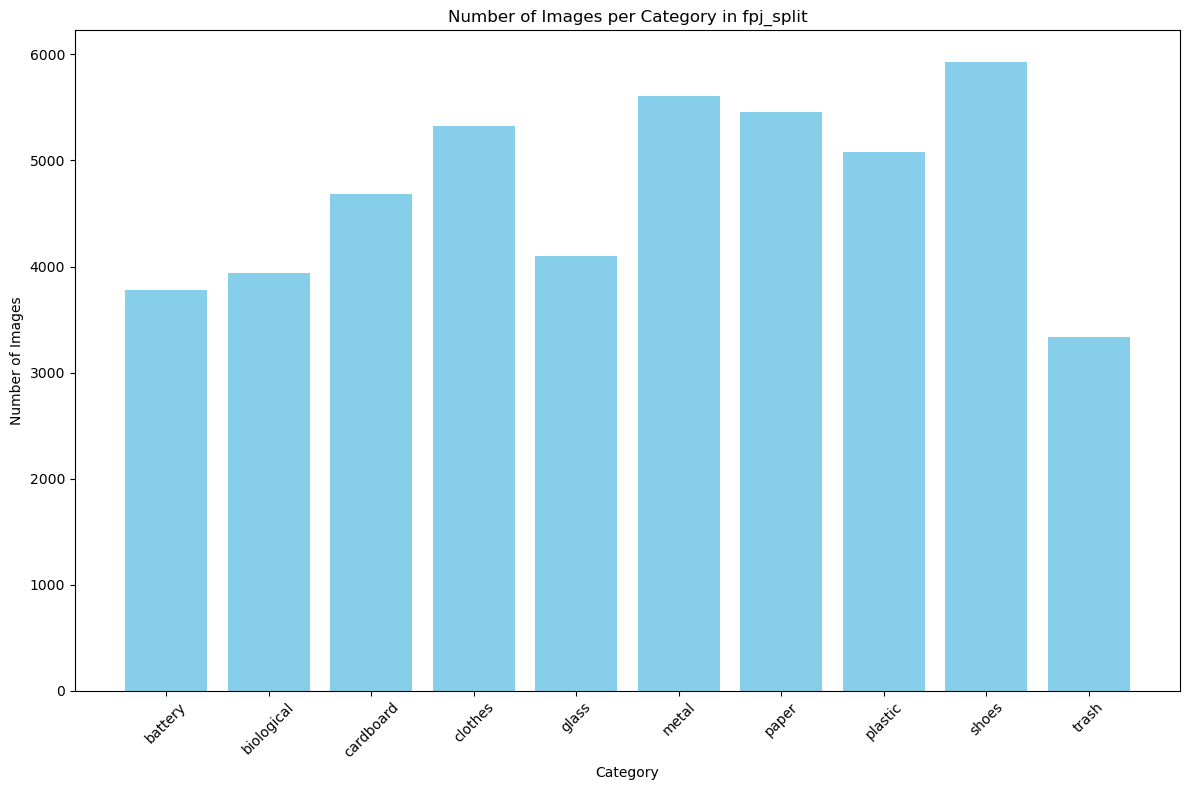

In [23]:
import os
import matplotlib.pyplot as plt

def count_images_in_directory(directory):
    category_counts = {}
    for category_name in os.listdir(directory):
        category_directory = os.path.join(directory, category_name)
        if os.path.isdir(category_directory):
            file_list = os.listdir(category_directory)
            category_counts[category_name] = len(file_list)
    return category_counts

def plot_image_counts(category_counts):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())

    plt.figure(figsize=(12, 8))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Category in fpj_split')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# fpj_split 디렉토리 경로
output_directory = './fpj_split'

# 디렉토리 내 이미지 수 세기
category_counts = count_images_in_directory(output_directory)

# 바 플롯 시각화
plot_image_counts(category_counts)


In [1]:
import cv2
import os
import numpy as np
# 데이터 디렉토리 경로
base_directory = './fpj_split'
# 사용할 카테고리 폴더 이름
category_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
# 리사이즈할 목표 크기 설정
target_size = (224, 224)
# 저장할 디렉토리 설정
output_base_directory = './fpj_resized'
# output_base_directory 폴더가 존재하지 않으면 생성
if not os.path.exists(output_base_directory):
    os.makedirs(output_base_directory)
for category_name in category_names:
    category_directory = os.path.join(base_directory, category_name)
    output_category_directory = os.path.join(output_base_directory, category_name)
    # output_category_directory 폴더가 존재하지 않으면 생성
    if not os.path.exists(output_category_directory):
        os.makedirs(output_category_directory)
    file_list = os.listdir(category_directory)
    for file_name in file_list:
        image_path = os.path.join(category_directory, file_name)
        # 이미지 읽기 (OpenCV 사용)
        image = cv2.imread(image_path)
        # 현재 이미지 크기
        h, w, _ = image.shape
        # 정사각형 패딩 계산
        if h > w:
            diff = h - w
            pad_left = diff // 2
            pad_right = diff - pad_left
            pad_top, pad_bottom = 0, 0
        else:
            diff = w - h
            pad_top = diff // 2
            pad_bottom = diff - pad_top
            pad_left, pad_right = 0, 0
        # 외삽법을 사용하여 패딩 추가
        padded_image = cv2.copyMakeBorder(
            image,
            pad_top, pad_bottom,
            pad_left, pad_right,
            cv2.BORDER_REPLICATE
        )
        # 패딩 후 리사이즈
        resized_image = cv2.resize(padded_image, target_size)
        # 처리된 이미지 저장
        output_path = os.path.join(output_category_directory, f'resized_{file_name}')
        cv2.imwrite(output_path, resized_image)
        print(f"처리된 이미지가 저장되었습니다: {output_path}")

처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_1.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_10.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_100.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_100_flip_both.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_100_flip_lr.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_100_flip_ud.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_101.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_101_flip_both.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_101_flip_lr.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_101_flip_ud.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_102.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_102_flip_both.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_102_flip_lr.jpg
처리된 이미지가 저장되었습니다: ./fpj_resized\battery\resized_battery_102_flip_ud.jpg
처리된 이미지가 저장되었습니다: ./fpj_resiz

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = './fpj_resized'
output_dir = './final'
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Train, val 폴더 생성
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(output_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', cls), exist_ok=True)
    
    class_dir = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
        
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))

print("Data splitting completed.")

Data splitting completed.


In [ ]:
# import os
# import torch
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms, models
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.metrics import recall_score, confusion_matrix
# import seaborn as sns
# import numpy as np

# # 데이터 전처리
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize((128, 128)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize((128, 128)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = './pj_split'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
#                for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # ResNet-18 모델 불러오기 및 수정
# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(class_names))

# model = model.to(device)

# # 학습 및 평가 함수
# def train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10):
#     train_loss_history = []
#     val_loss_history = []
#     train_acc_history = []
#     val_acc_history = []
#     train_recall_history = []
#     val_recall_history = []
    
#     for epoch in range(start_epoch, start_epoch + num_epochs):
#         epoch_str = f'Epoch {epoch}/{start_epoch + num_epochs - 1}'
#         print(epoch_str)
        
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()
            
#             running_loss = 0.0
#             running_corrects = 0
#             all_preds = []
#             all_labels = []
            
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
                
#                 optimizer.zero_grad()
                
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)
                    
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
                
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
                
#                 # GPU 메모리 정리
#                 del inputs, labels, outputs, preds
#                 torch.cuda.empty_cache()
            
#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
#             epoch_recall = recall_score(all_labels, all_preds, average='macro')
            
#             if phase == 'train':
#                 train_loss_history.append(epoch_loss)
#                 train_acc_history.append(epoch_acc.item())
#                 train_recall_history.append(epoch_recall)
#             else:
#                 val_loss_history.append(epoch_loss)
#                 val_acc_history.append(epoch_acc.item())
#                 val_recall_history.append(epoch_recall)
            
#             log_str = f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {epoch_recall:.4f}'
#             print(log_str)
        
#         print()

#     return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history

# # 손실 함수 및 최적화기 설정
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 모델 학습
# model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history = train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10)

# # 모델 저장
# torch.save(model.state_dict(), 'recycle_classification_model_resnet18.pth')

# # 시각화
# epochs = list(range(1, len(train_loss_history) + 1))

# # 학습 및 검증 손실 시각화
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_loss_history, label='Train Loss')
# plt.plot(epochs, val_loss_history, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.show()

# # 학습 및 검증 정확도 시각화
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_acc_history, label='Train Accuracy')
# plt.plot(epochs, val_acc_history, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')
# plt.show()

# # 학습 및 검증 리콜 시각화
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_recall_history, label='Train Recall')
# plt.plot(epochs, val_recall_history, label='Validation Recall')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.legend()
# plt.title('Training and Validation Recall')
# plt.show()

# # 모델 평가 및 혼동 행렬 계산 함수
# def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
#     model.eval()
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
    
#     # 혼동 행렬 계산
#     cm = confusion_matrix(all_labels, all_preds)
    
#     # 비율로 변환
#     cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
#     # 혼동 행렬 시각화
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Normalized Confusion Matrix')
#     plt.show()

# # 클래스 이름 설정
# class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

# # 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
# evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)


c:\ProgramData\anaconda3\envs\ma\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\ma\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\User/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%


Epoch 0/9
train Loss: 0.7755 Acc: 0.7525 Recall: 0.7477
val Loss: 0.4351 Acc: 0.8637 Recall: 0.8633

Epoch 1/9
train Loss: 0.5020 Acc: 0.8390 Recall: 0.8351
val Loss: 0.3935 Acc: 0.8714 Recall: 0.8685

Epoch 2/9
train Loss: 0.4052 Acc: 0.8700 Recall: 0.8670
val Loss: 0.3254 Acc: 0.8997 Recall: 0.8964

Epoch 3/9
train Loss: 0.3390 Acc: 0.8901 Recall: 0.8876
val Loss: 0.2759 Acc: 0.9156 Recall: 0.9129

Epoch 4/9
train Loss: 0.2972 Acc: 0.9039 Recall: 0.9022
val Loss: 0.2797 Acc: 0.9108 Recall: 0.9088

Epoch 5/9
train Loss: 0.2597 Acc: 0.9167 Recall: 0.9151
val Loss: 0.2671 Acc: 0.9173 Recall: 0.9171

Epoch 6/9
train Loss: 0.2325 Acc: 0.9248 Recall: 0.9231
val Loss: 0.2466 Acc: 0.9197 Recall: 0.9201

Epoch 7/9
train Loss: 0.2170 Acc: 0.9291 Recall: 0.9277
val Loss: 0.2447 Acc: 0.9235 Recall: 0.9251

Epoch 8/9
train Loss: 0.1974 Acc: 0.9344 Recall: 0.9331
val Loss: 0.2351 Acc: 0.9293 Recall: 0.9278

Epoch 9/9
train Loss: 0.1838 Acc: 0.9389 Recall: 0.9375
val Loss: 0.1987 Acc: 0.9387 Recall

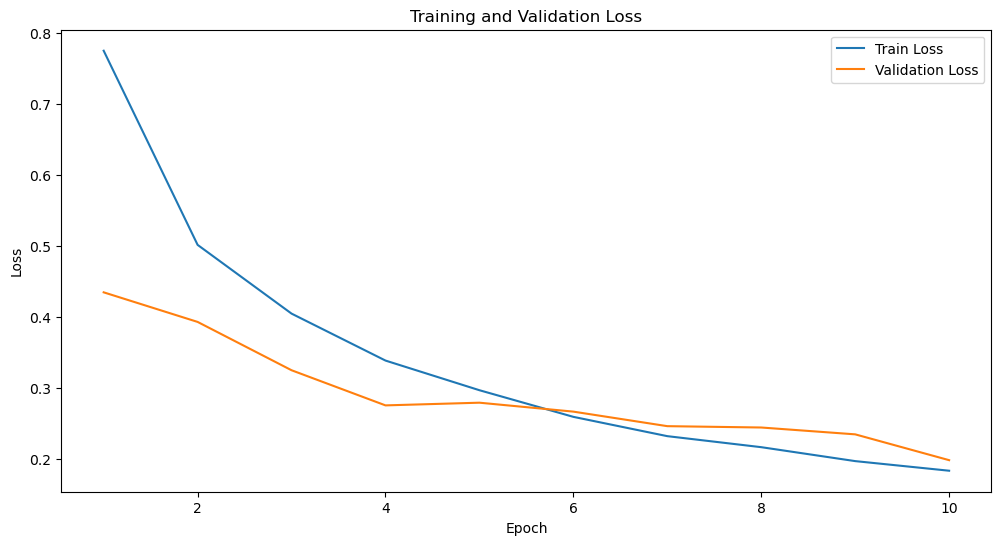

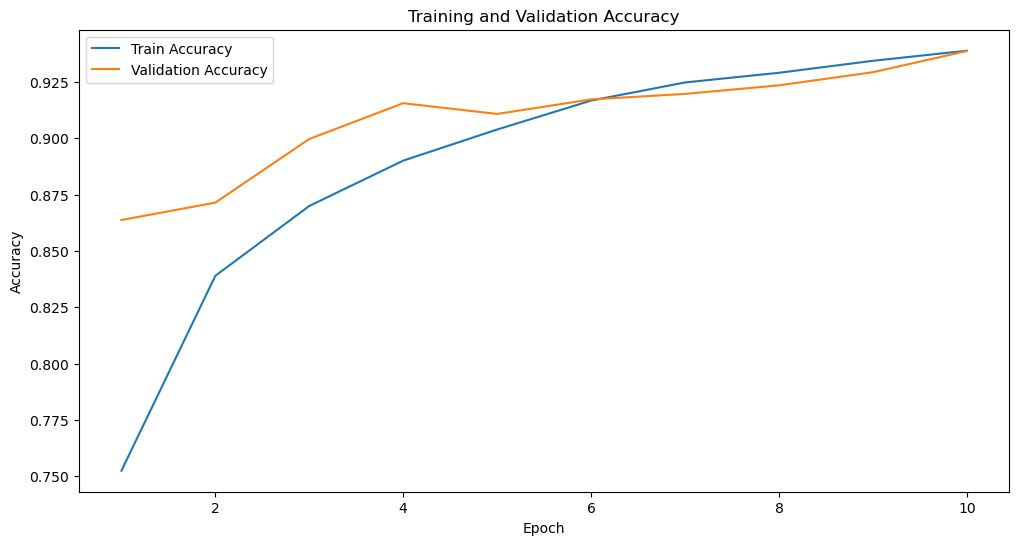

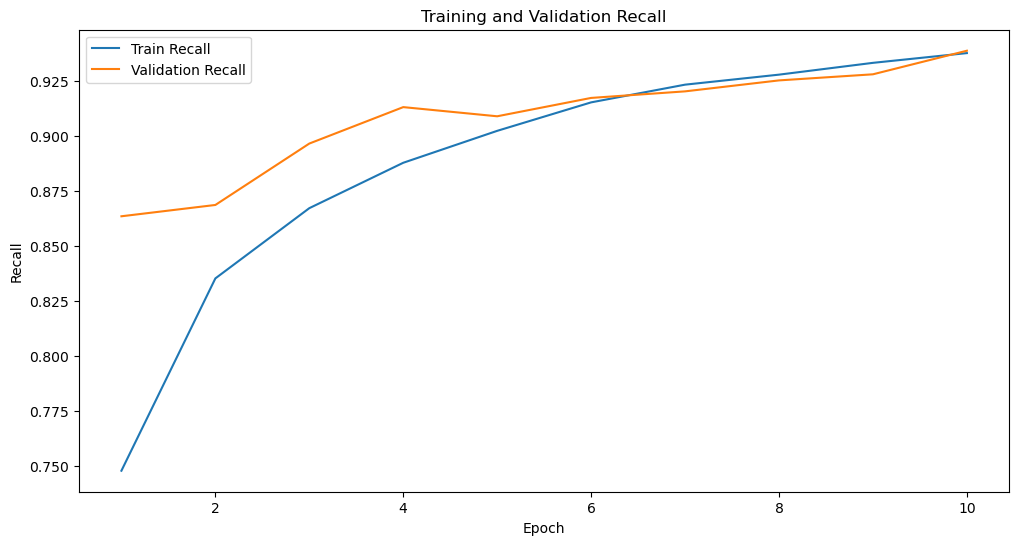

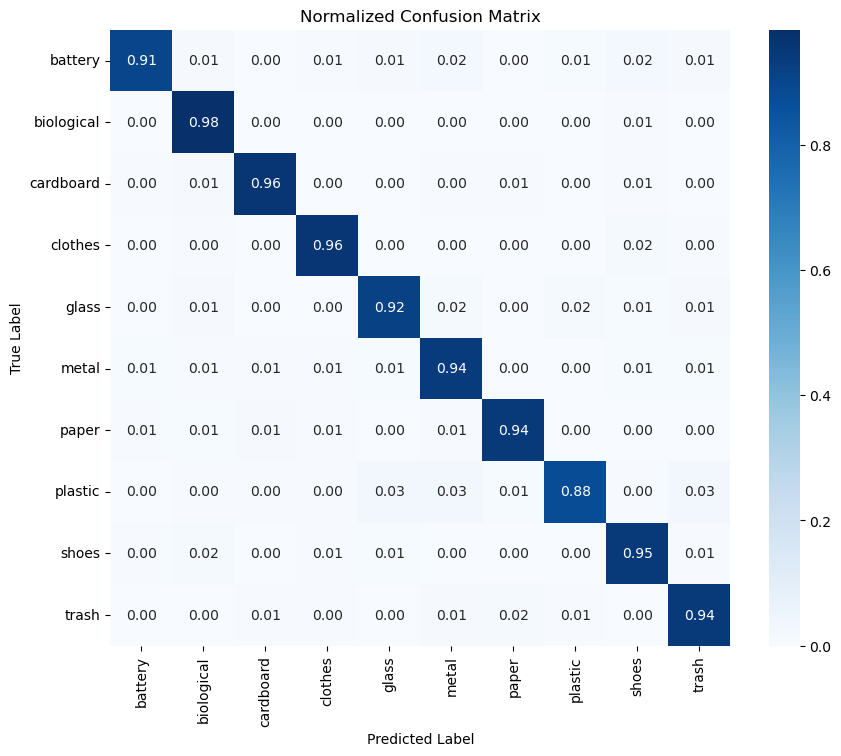

In [3]:
#모바일넷
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
import numpy as np

# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './final'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MobileNet 모델 불러오기 및 수정
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# 학습 및 평가 함수
def train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    train_recall_history = []
    val_recall_history = []
    
    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_str = f'Epoch {epoch}/{start_epoch + num_epochs - 1}'
        print(epoch_str)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # GPU 메모리 정리
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                train_recall_history.append(epoch_recall)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_recall_history.append(epoch_recall)
            
            log_str = f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {epoch_recall:.4f}'
            print(log_str)
        
        print()

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history = train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10)

# 모델 저장
torch.save(model.state_dict(), 'recycle_classification_model_mobilenetv2.pth')

# 시각화
epochs = list(range(1, len(train_loss_history) + 1))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_recall_history, label='Train Recall')
plt.plot(epochs, val_recall_history, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()

# 모델 평가 및 혼동 행렬 계산 함수
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# 클래스 이름 설정
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

# 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)


Epoch 10/29
train Loss: 0.1681 Acc: 0.9455 Recall: 0.9441
val Loss: 0.2228 Acc: 0.9320 Recall: 0.9335

Epoch 11/29
train Loss: 0.1606 Acc: 0.9473 Recall: 0.9461
val Loss: 0.1805 Acc: 0.9436 Recall: 0.9412

Epoch 12/29
train Loss: 0.1496 Acc: 0.9516 Recall: 0.9507
val Loss: 0.2230 Acc: 0.9357 Recall: 0.9348

Epoch 13/29
train Loss: 0.1404 Acc: 0.9536 Recall: 0.9526
val Loss: 0.1735 Acc: 0.9472 Recall: 0.9467

Epoch 14/29
train Loss: 0.1310 Acc: 0.9570 Recall: 0.9563
val Loss: 0.1799 Acc: 0.9472 Recall: 0.9460

Epoch 15/29
train Loss: 0.1253 Acc: 0.9591 Recall: 0.9584
val Loss: 0.1688 Acc: 0.9466 Recall: 0.9442

Epoch 16/29
train Loss: 0.1190 Acc: 0.9608 Recall: 0.9600
val Loss: 0.1867 Acc: 0.9482 Recall: 0.9457

Epoch 17/29
train Loss: 0.1071 Acc: 0.9656 Recall: 0.9650
val Loss: 0.1684 Acc: 0.9494 Recall: 0.9489

Epoch 18/29
train Loss: 0.1112 Acc: 0.9626 Recall: 0.9622
val Loss: 0.1730 Acc: 0.9458 Recall: 0.9445

Epoch 19/29
train Loss: 0.1012 Acc: 0.9666 Recall: 0.9657
val Loss: 0.183

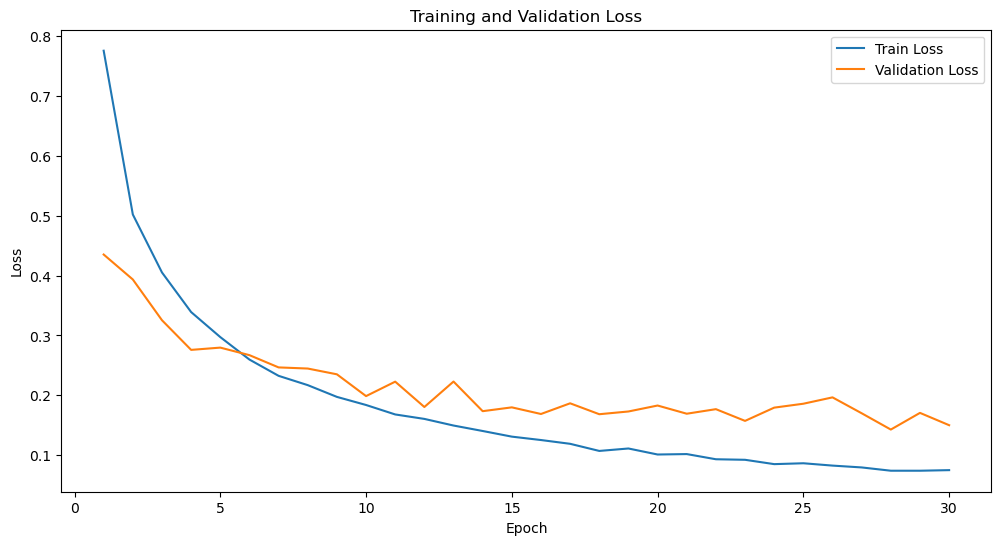

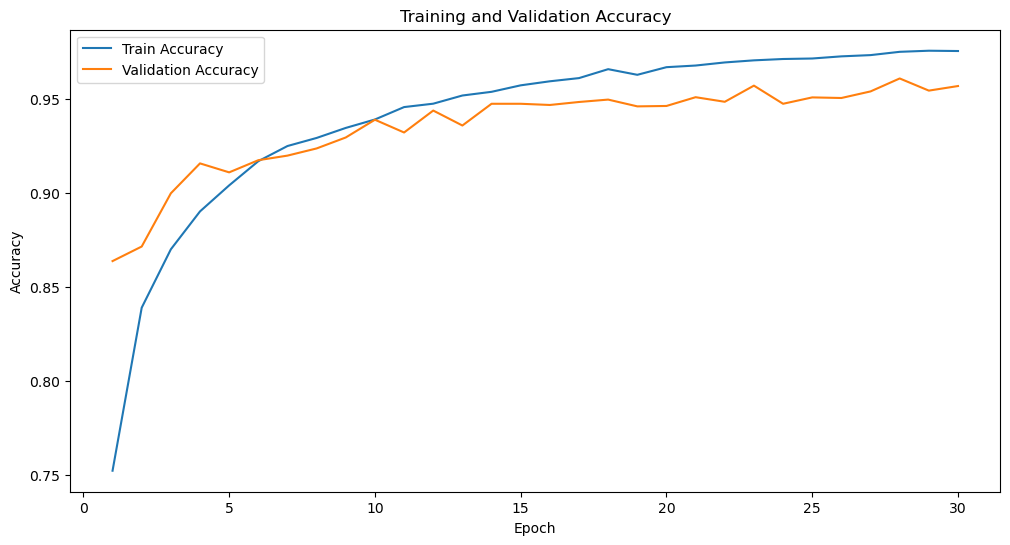

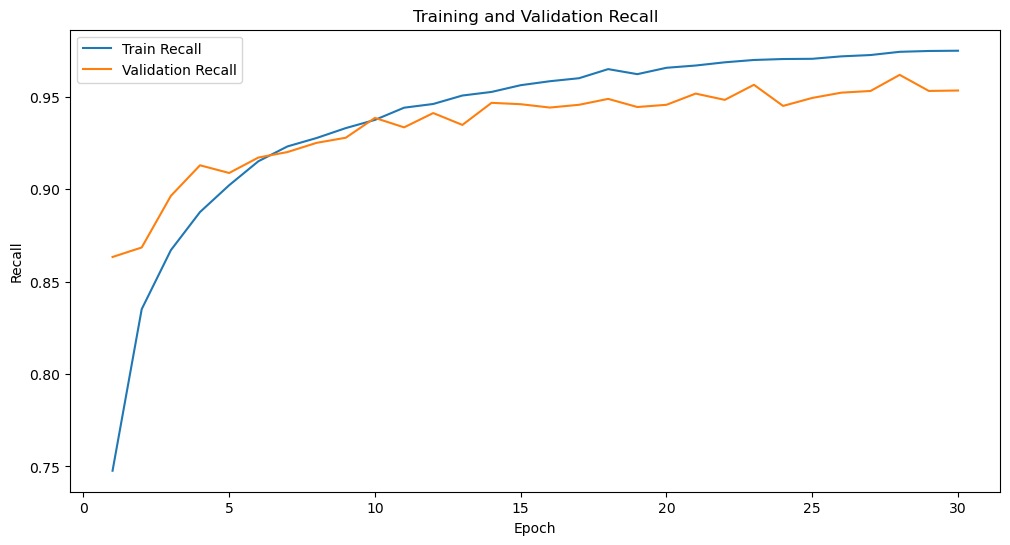

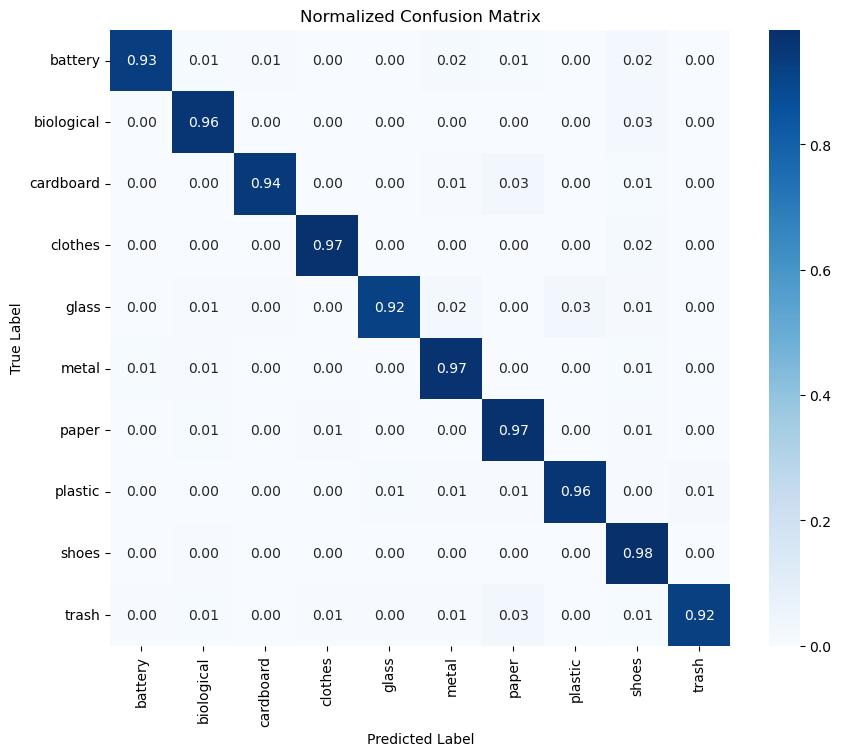

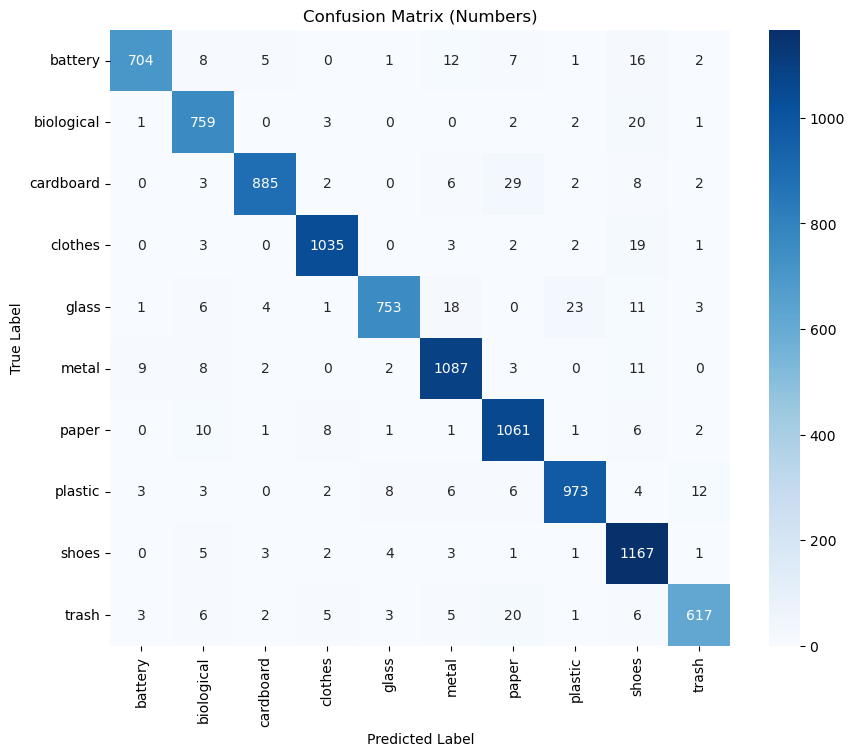

In [4]:
#모바일넷 추가학습
# 기존 모델 상태 불러오기
model.load_state_dict(torch.load('recycle_classification_model_mobilenetv2.pth'))

# 추가 학습 수행
additional_model, additional_train_loss, additional_val_loss, additional_train_acc, additional_val_acc, additional_train_recall, additional_val_recall = train_model(model, criterion, optimizer, start_epoch=10, num_epochs=20)

# 기존 기록에 추가 학습 기록을 병합
train_loss_history.extend(additional_train_loss)
val_loss_history.extend(additional_val_loss)
train_acc_history.extend(additional_train_acc)
val_acc_history.extend(additional_val_acc)
train_recall_history.extend(additional_train_recall)
val_recall_history.extend(additional_val_recall)

# 모델 저장 (추가 학습 후)
torch.save(model.state_dict(), 'recycle_classification_model_mobilenetv2_further.pth')

# 시각화 업데이트
epochs = list(range(1, len(train_loss_history) + 1))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_recall_history, label='Train Recall')
plt.plot(epochs, val_recall_history, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()

# 혼동 행렬 시각화 업데이트
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 시각화 - 비율
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    # 혼동 행렬 시각화 - 숫자
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Numbers)')
    plt.show()

# 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)

In [ ]:
# import time
# start_time = time.time()
# for epoch in range(0,10):
#     start_epoch = time.time()
#     train(model, train_loader, optimizer, epoch)
#     test(model, test_loader)
#     elapsed_time = time.time() - start_epoch
#     print(f"Epoch time: {elapsed_time:.2f} seconds")
# elapsed_time = time.time() - start_time
# print(f"Total elapsed time: {elapsed_time:.2f} seconds")
# import random
# # Define the hyperparameter search space
# learning_rate_range = [np.exp(x) for x in np.random.randint(-4,-1,100)]
# weight_decay_range = [np.exp(x) for x in np.random.randint(-4,-1,100)]
# dropout_range = [0.1, 0.2, 0.3, 0.4, 0.5]
# num_epochs = 10  # Number of epochs
# # Define the number of random search iterations
# num_iterations = 10
# # Initialize lists to store the results
# train_losses = []
# train_accuracies = []
# best_train_loss = float('inf')
# best_train_accuracy = 0
# best_hyperparams = {}
# for i in range(num_iterations):
#     # Randomly sample hyperparameters from the search space
#     learning_rate = random.choice(learning_rate_range)
#     weight_decay = random.choice(weight_decay_range)
#     dropout = random.choice(dropout_range)
#     # Update the model's hyperparameters
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     model.dropout.p = dropout
#     # Train the model for the specified number of epochs
#     epoch_losses = []
#     epoch_accuracies = []
#     start_time = time.time()
#     #epoch start
#     for epoch in range(0,num_epochs):
#         start_epoch = time.time()
#         train(model, train_loader, optimizer, epoch)
#         test(model, test_loader)
#         elapsed_time = time.time() - start_epoch
#         print(f"Epoch time: {elapsed_time:.2f} seconds")
#     elapsed_time = time.time() - start_time
#     print(f"Total elapsed time: {elapsed_time:.2f} seconds")
#     # Calculate the average train loss and accuracy over the epochs
#     avg_train_loss = sum(epoch_losses) / num_epochs
#     avg_train_accuracy = sum(epoch_accuracies) / num_epochs
#     # Update the best hyperparameters and results
#     if avg_train_loss < best_train_loss:
#         best_train_loss = avg_train_loss
#         best_train_accuracy = avg_train_accuracy
#         best_hyperparams = {
#             'learning_rate': learning_rate,
#             'weight_decay': weight_decay,
#             'dropout': dropout
#         }
#     # Append the current iteration's results to the lists
#     train_losses.append(avg_train_loss)
#     train_accuracies.append(avg_train_accuracy)
#     print(f"Iteration {i+1}: Avg Train Loss: {avg_train_loss:.4f}, Avg Train Accuracy: {avg_train_accuracy:.2f}%")
# print(f"Best hyperparameters: {best_hyperparams}")
# print(f"Best train loss: {best_train_loss:.4f}, Best train accuracy: {best_train_accuracy:.2f}%")